In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import scipy.stats as ss
import pickle

In [3]:
# import sys
# !conda install --yes --prefix {sys.prefix} -c conda-forge nbresuse

# import sys
# !{sys.executable} -m pip install numpy

In [4]:
pd.options.display.max_rows = 150
pd.options.display.max_columns = 100

In [4]:
TARGET = 'target_full_ltv_day30'
subtargs = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']
cat_cols = ['media_source', 'country_code', 'platform'] + [f'retained_day{i}' for i in [7]]
time_cols = ['install_date']
num_cols = [f'chapters_finished_day{i}' for i in [7]] + \
[f'chapters_opened_day{i}' for i in [7]]
# [col for col in us.columns.values if col not in cat_cols]

In [5]:
# us = pd.read_csv('./datasets/task.csv')[cat_cols + time_cols + [TARGET]]
us = pd.read_pickle('./datasets/us.pkl')

In [7]:
# us = us.rename(columns={'chapters_finished_day7': 'chapters_finished',
#                'chapters_opened_day7': 'chapters_opened',
#                'retained_day7': 'retained'})

In [10]:
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467832 entries, 0 to 1467831
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   chapters_finished_day7  1467832 non-null  int64         
 1   chapters_opened_day7    1467832 non-null  int64         
 2   retained_day7           1467832 non-null  int64         
 3   media_source            1467832 non-null  object        
 4   install_date            1467832 non-null  datetime64[ns]
 5   country_code            1467832 non-null  object        
 6   platform                1467832 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 78.4+ MB


In [9]:
def show_distribution(df, features):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(n*3, n*3))

    for i, feature in enumerate(features):
        data = df[feature]

        ax1, ax2 = axes[i, 0], axes[i, 1]

        sns.distplot(data, ax=ax1)
        sns.boxplot(None, data, ax=ax2)

        ax1.set_title(f'{feature} Density')
        ax2.set_title(f'{feature} Boxplot')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()
    
def show_cat_distribution(df, features):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(1*5, n*5))

    for i, feature in enumerate(features):
        ax = axes[i]

        sns.histplot(df, x=feature, ax=ax, discrete=True, shrink=0.8)

        ax.set_title(f'{feature} Count Plot')
        ax.tick_params(axis='x', labelrotation=-90)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()
    
    fig.clear()
    plt.close(fig)

In [20]:
def handle_outliers(df, feature, method='replace'):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1

    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)

    print(q1, q3)
    print(lower_bound, upper_bound)


    if method == 'replace':
        df.loc[df[feature] > upper_bound, feature] = q3
        df.loc[df[feature] < lower_bound, feature] = q1

    elif method == 'drop':
        df = df[(df[feature] < upper_bound) & (df[feature] > lower_bound)]
        
    elif method == 'predict':
        df.loc[df[feature] > upper_bound, feature] = np.nan
        df.loc[df[feature] < lower_bound, feature] = np.nan

        imputer = NaNImputer(nan_cols=[feature],
                             drop_empty_cols=False,
                             drop_nan_cols_with_constant=False,
                             verbose=False)
        df = imputer.impute(df)

    return df

/home/vivi/anaconda3/envs/iasa/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vivi/anaconda3/envs/iasa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vivi/anaconda3/envs/iasa/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `

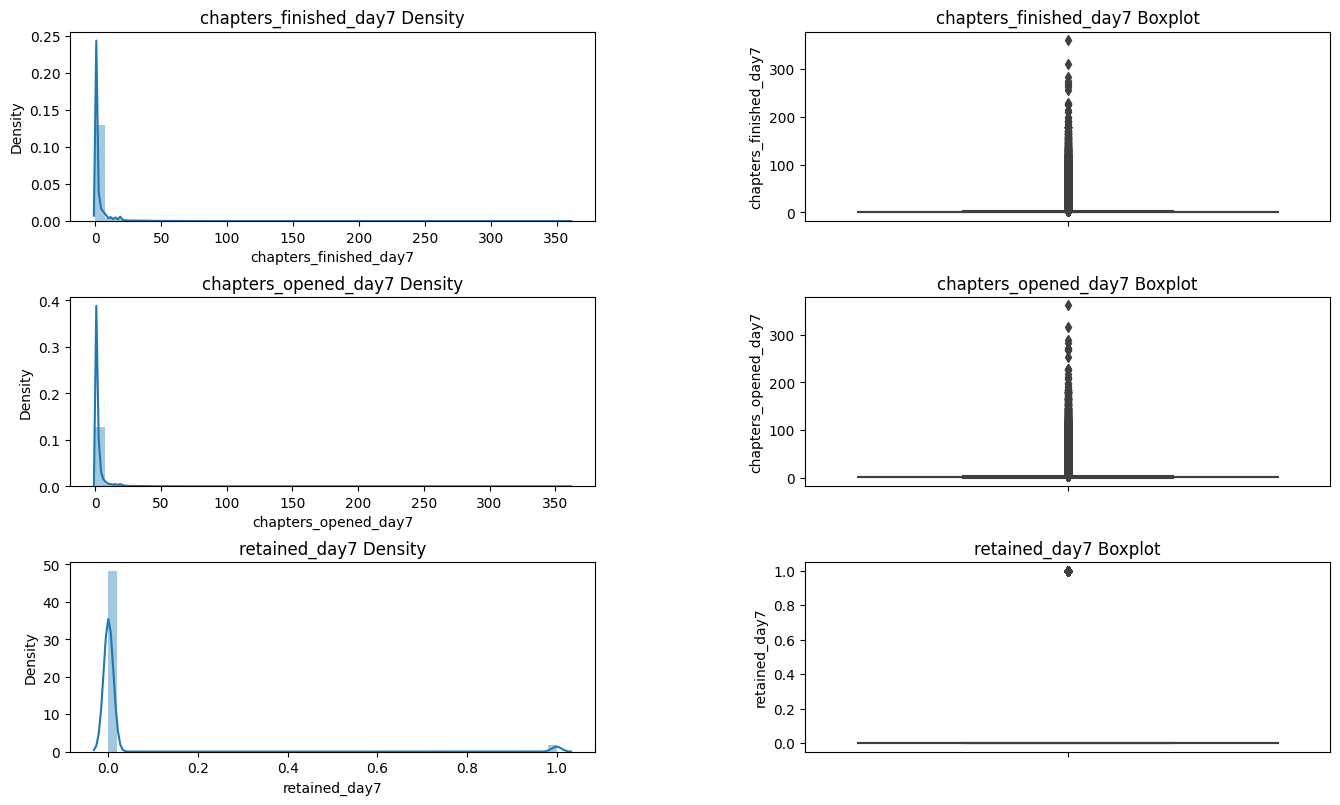

In [13]:
show_distribution(us, num_cols)

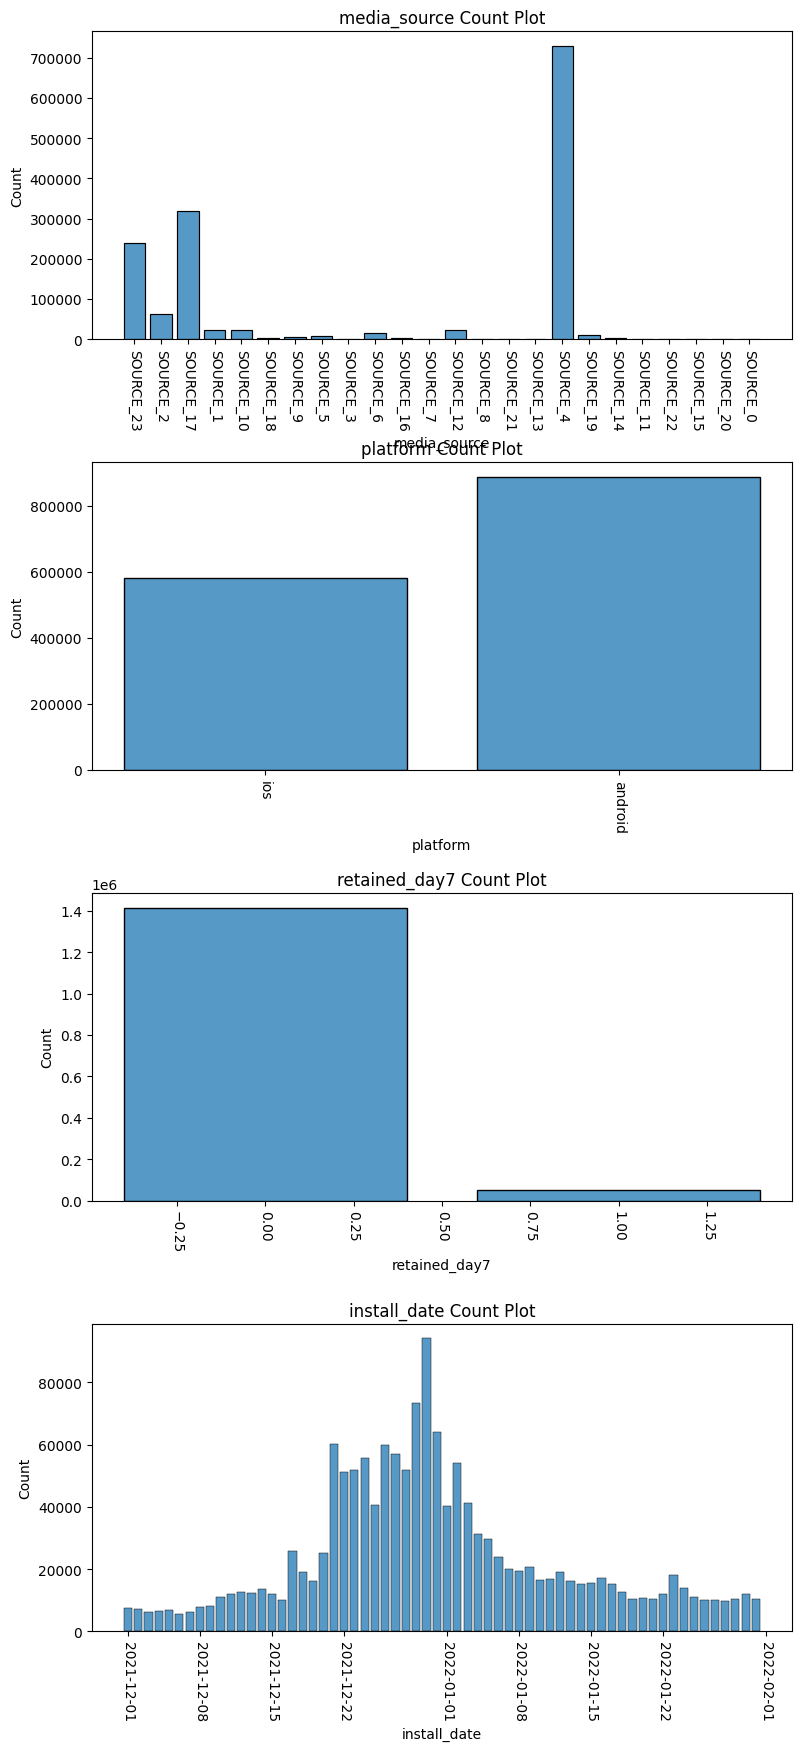

In [64]:
show_cat_distribution(us, [col for col in cat_cols + time_cols if col not in ['country_code']]) #imp

In [31]:
us.groupby('country_code')['country_code'].count().sort_values(ascending=False)[:10].index.values

array(['COUNTRY_141', 'COUNTRY_13', 'COUNTRY_155', 'COUNTRY_108',
       'COUNTRY_35', 'COUNTRY_137', 'COUNTRY_72', 'COUNTRY_38',
       'COUNTRY_208', 'COUNTRY_189'], dtype=object)

In [83]:
# us[us['country_code'] == 'COUNTRY_155']

In [8]:
def show_dis_by_group(df, group_feature, features, features_type='cont', fig_title='Figure'):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(1*5, n*5), num=1, clear=True)
    fig.suptitle(fig_title)

    for i, feature in enumerate(features):
        ax = axes[i]
        
        if features_type == 'cont':
            sns.histplot(df, x=feature, hue=group_feature, ax=ax, element="step", bins=50)
        elif features_type == 'cat':
            sns.histplot(df, x=feature, hue=group_feature, ax=ax, discrete=True, shrink=0.8)

        ax.set_title(f'{feature} Histogram')
        ax.tick_params(axis='x', labelrotation=-90)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=1.5, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    
    plt.show()
    
    fig.clear()
    plt.close(fig)

def ord_by_split(df, split_feat, bounds, choices=[0, 1, 2, 3]):
    lower_bound = bounds[0]
    middle_bound = bounds[1]
    upper_bound = bounds[2]
    print(lower_bound, middle_bound, upper_bound)
    conditions = [
        df[split_feat] <= lower_bound,
        df[split_feat].between(lower_bound, middle_bound, inclusive='right'),
        df[split_feat].between(middle_bound, upper_bound, inclusive='right'),
        df[split_feat] > upper_bound
    ]
    return np.select(conditions, choices)

In [9]:
us['activity'] = ord_by_split(us, 'chapters_opened_day7', [2, 6, 32])
us.tail()

2.0 6.0 32.0


chapters_finished_day7  chapters_opened_day7  retained_day7  \
1467827                       9                    10              0   
1467828                      13                    13              0   
1467829                      18                    19              0   
1467830                      24                    24              0   
1467831                      15                    16              0   

        media_source install_date country_code platform  activity  
1467827    SOURCE_17   2021-12-30  COUNTRY_141      ios         2  
1467828    SOURCE_23   2021-12-30  COUNTRY_141      ios         2  
1467829    SOURCE_23   2021-12-30  COUNTRY_141      ios         2  
1467830     SOURCE_4   2021-12-30  COUNTRY_141      ios         2  
1467831     SOURCE_1   2021-12-30  COUNTRY_141  android         2

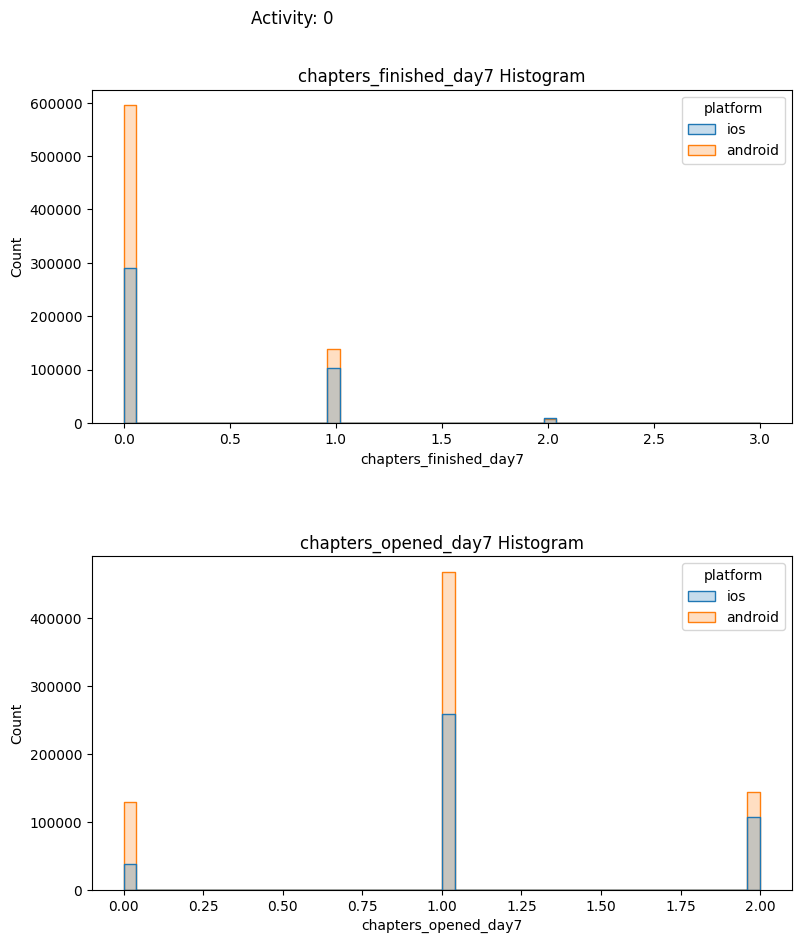

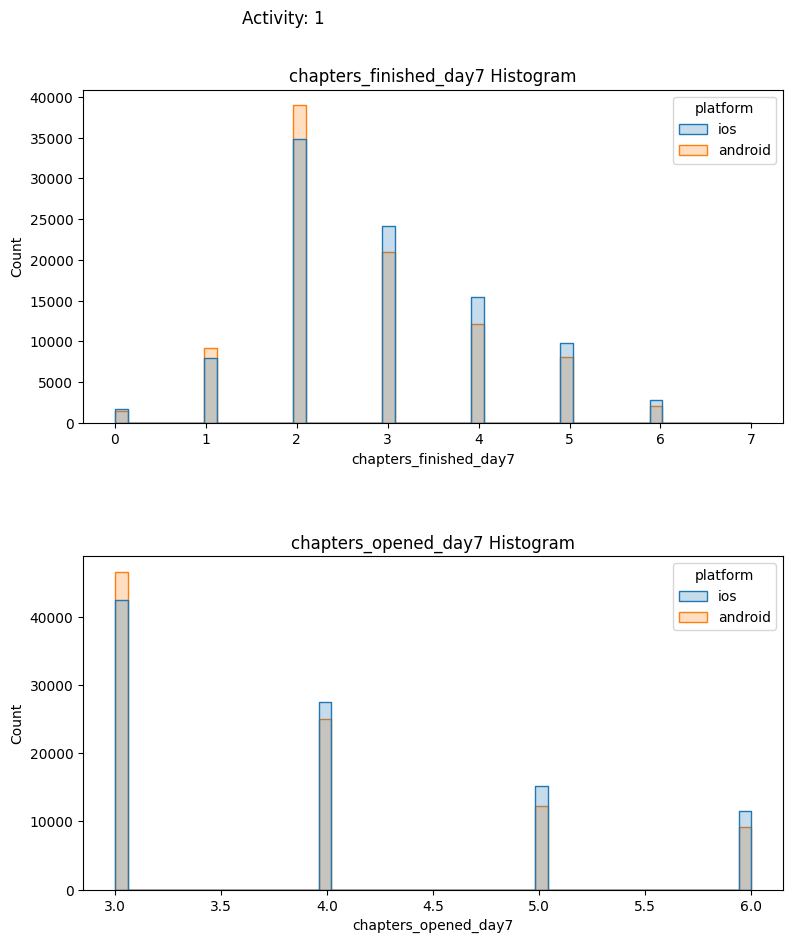

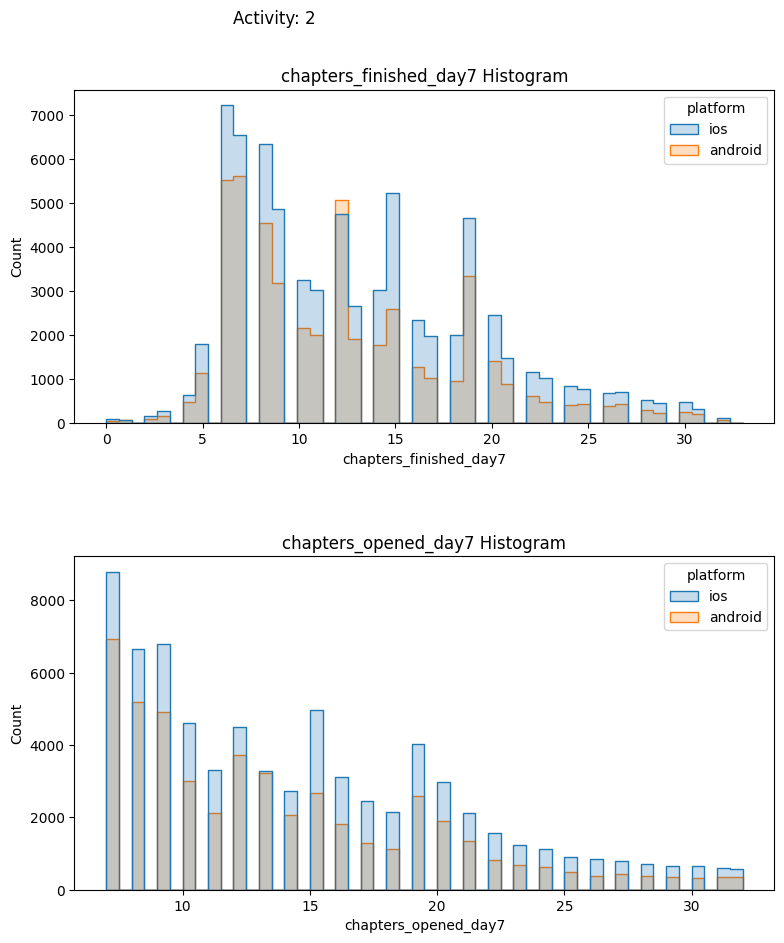

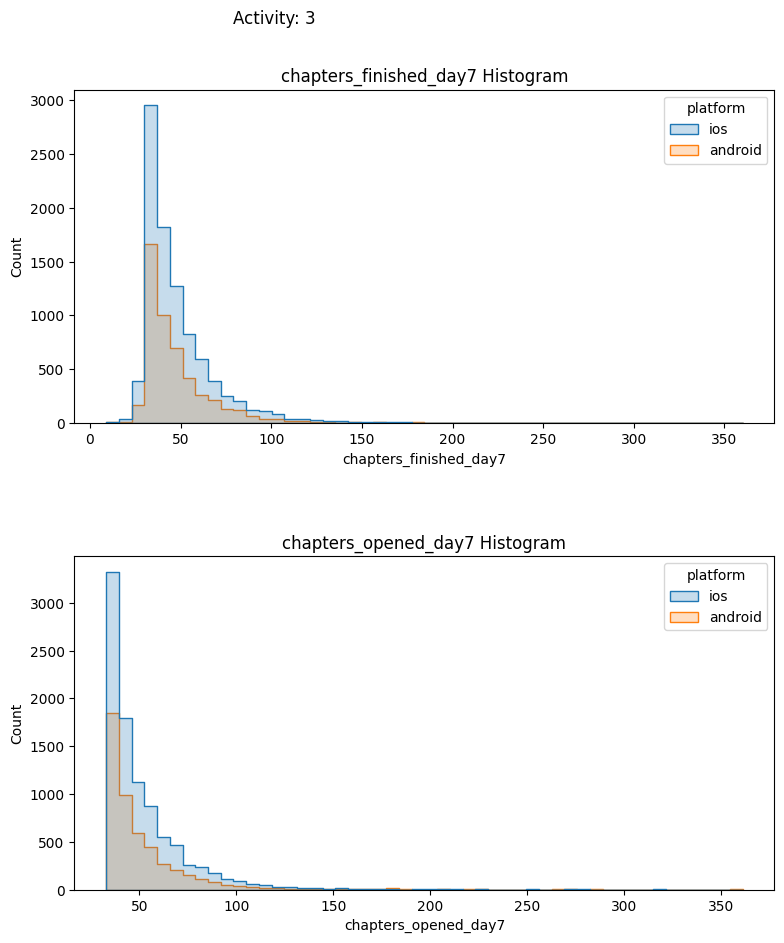

Empty DataFrame
Columns: []
Index: []

In [24]:
us.groupby('activity').apply(lambda x: show_dis_by_group(x, 'platform', num_cols, f'Activity: {x.name}'))

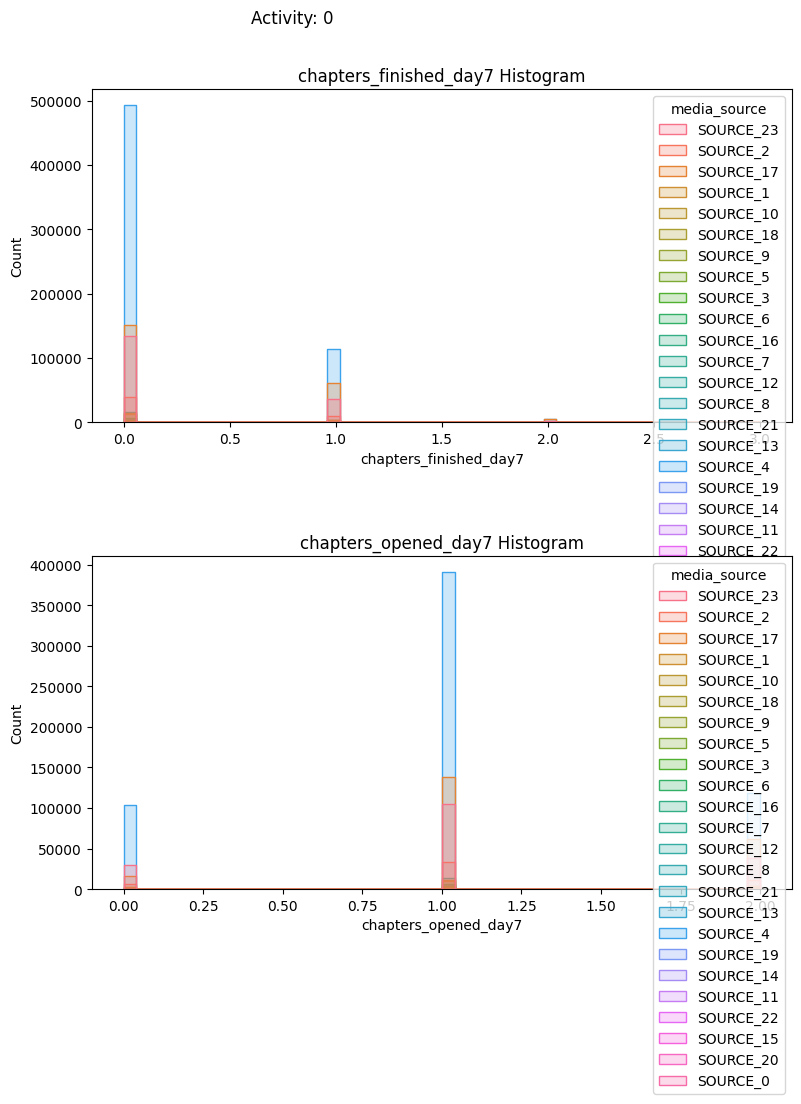

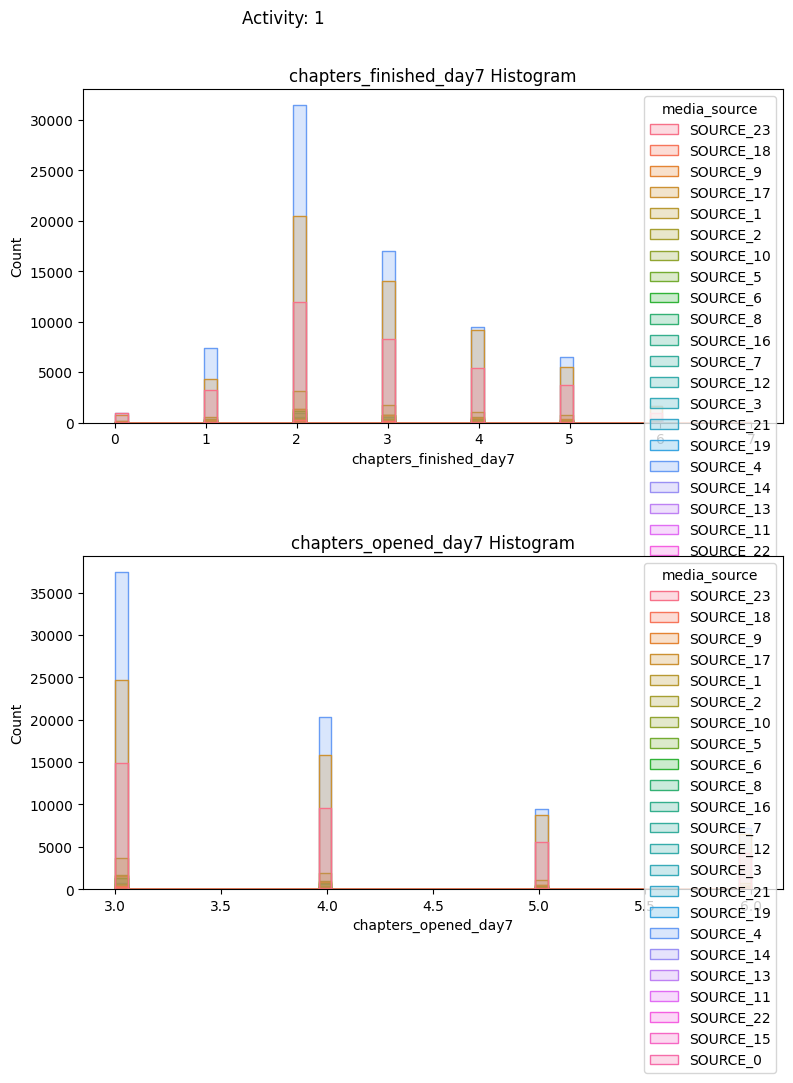

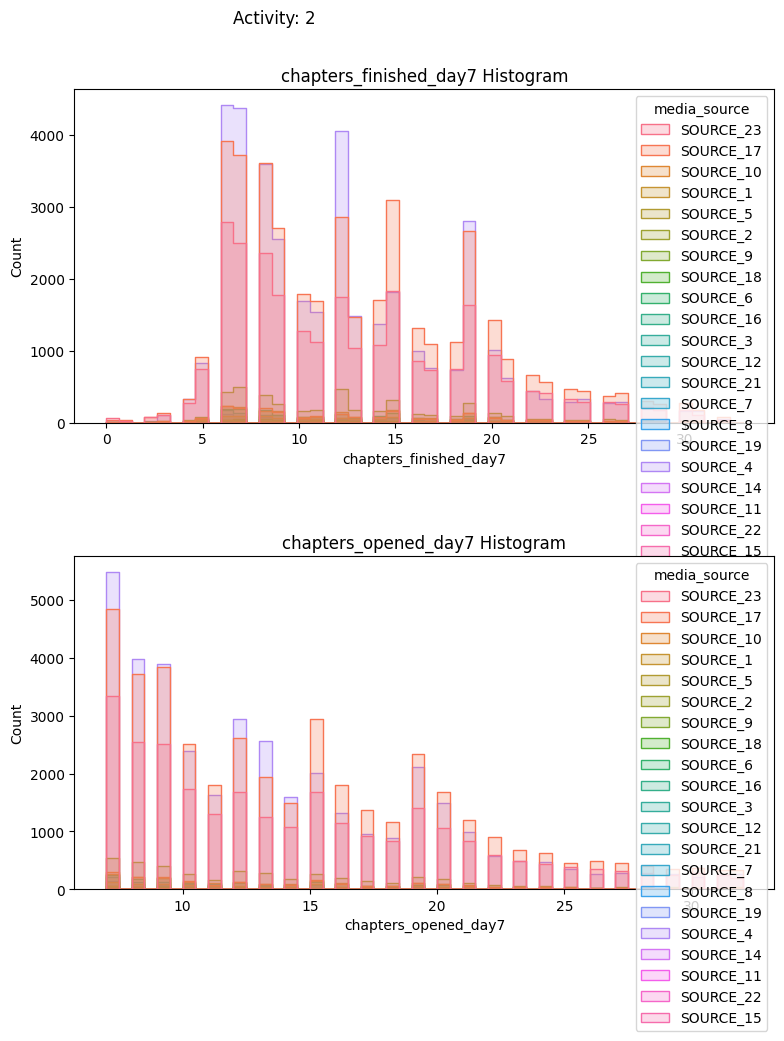

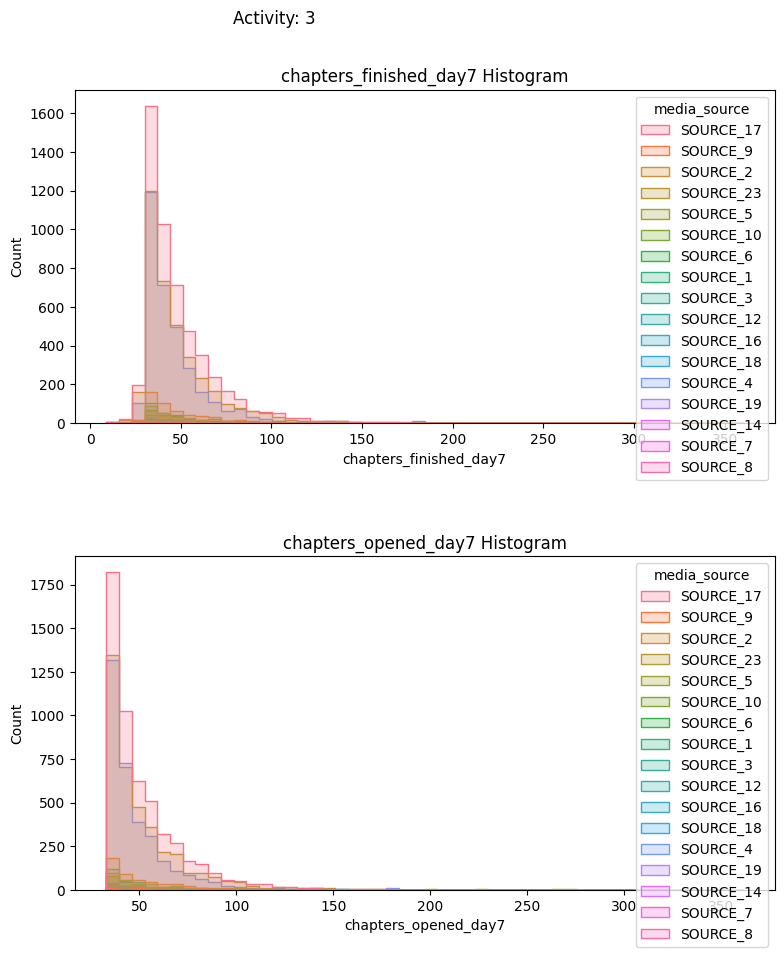

Empty DataFrame
Columns: []
Index: []

In [25]:
us.groupby('activity').apply(lambda x: show_dis_by_group(x, 'media_source', num_cols, f'Activity: {x.name}'))

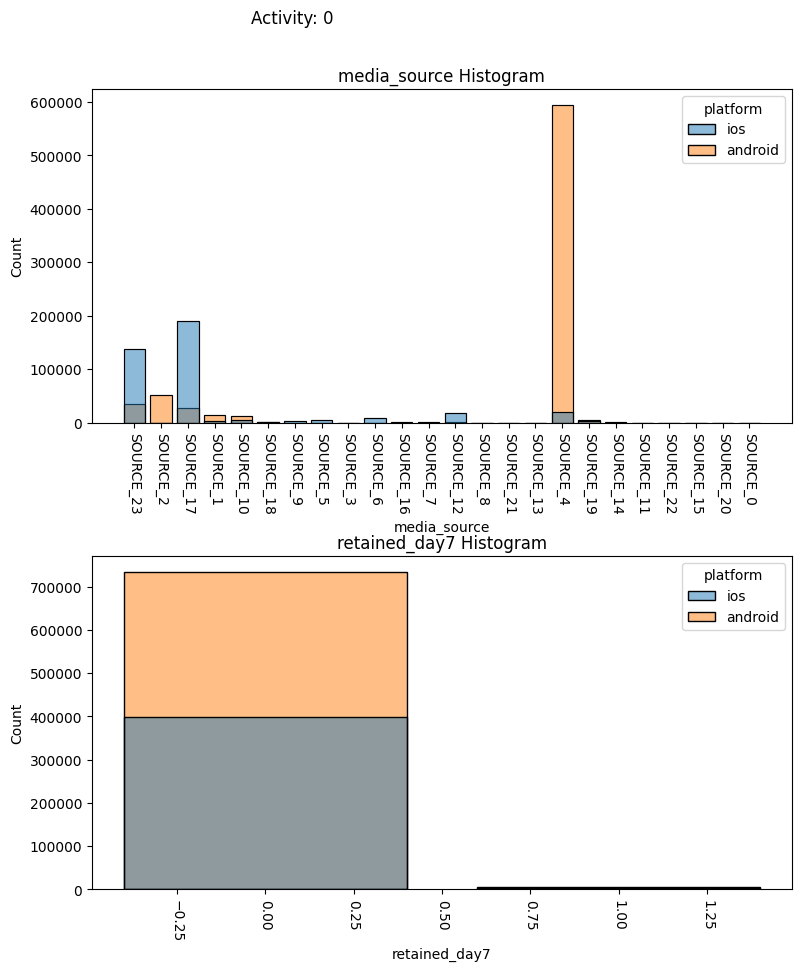

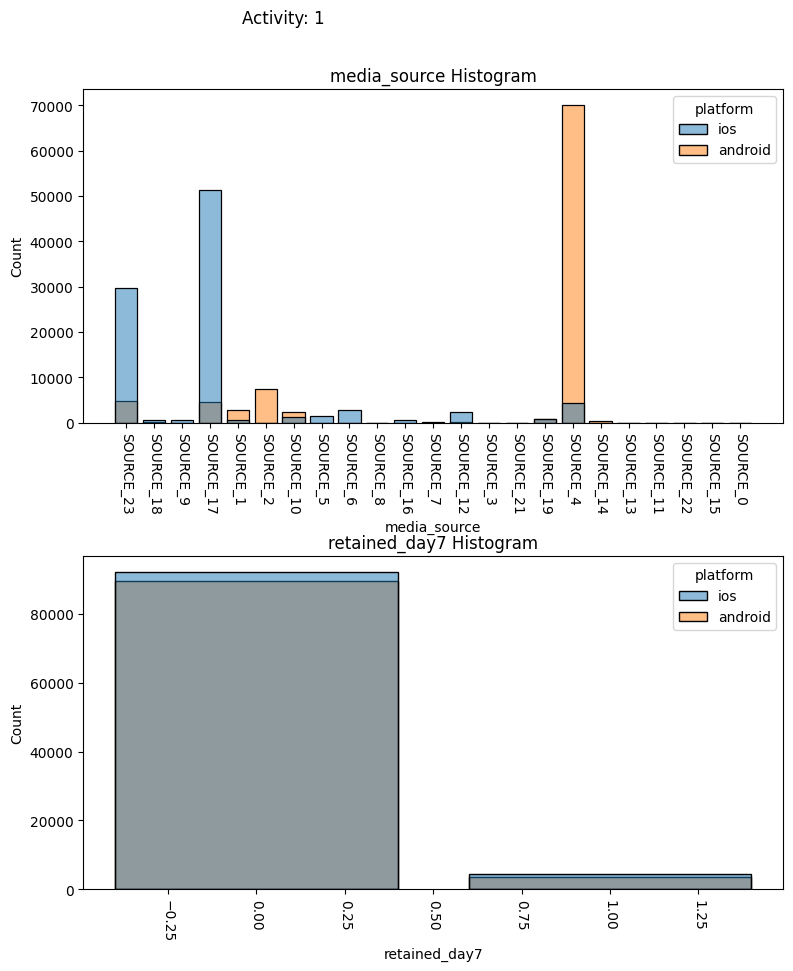

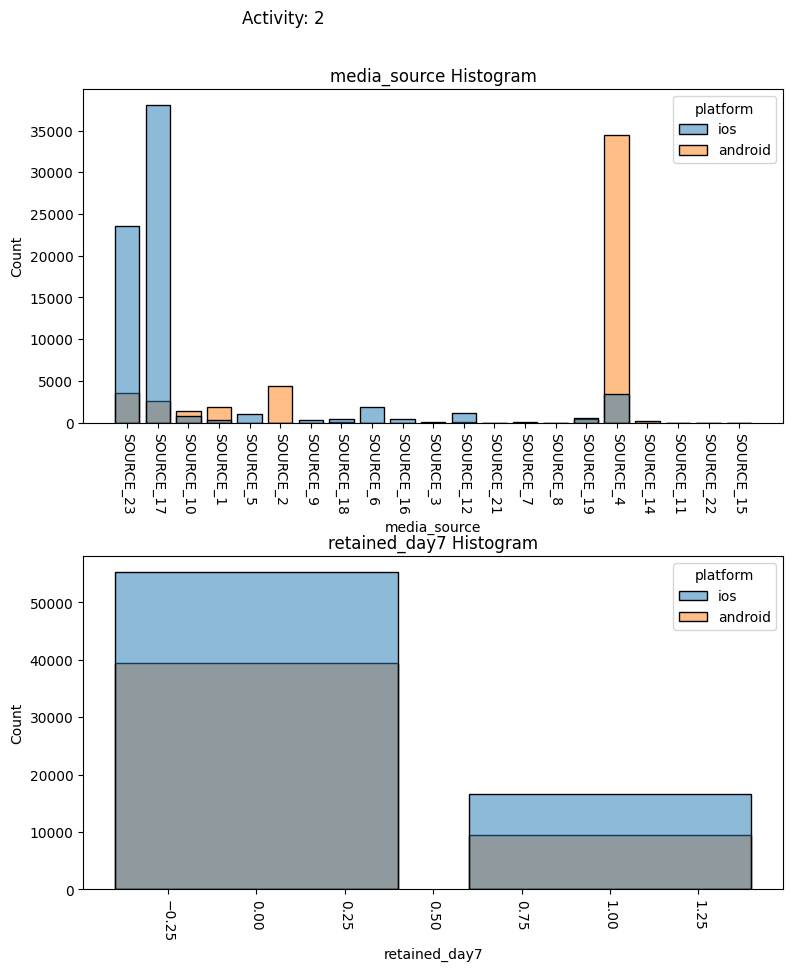

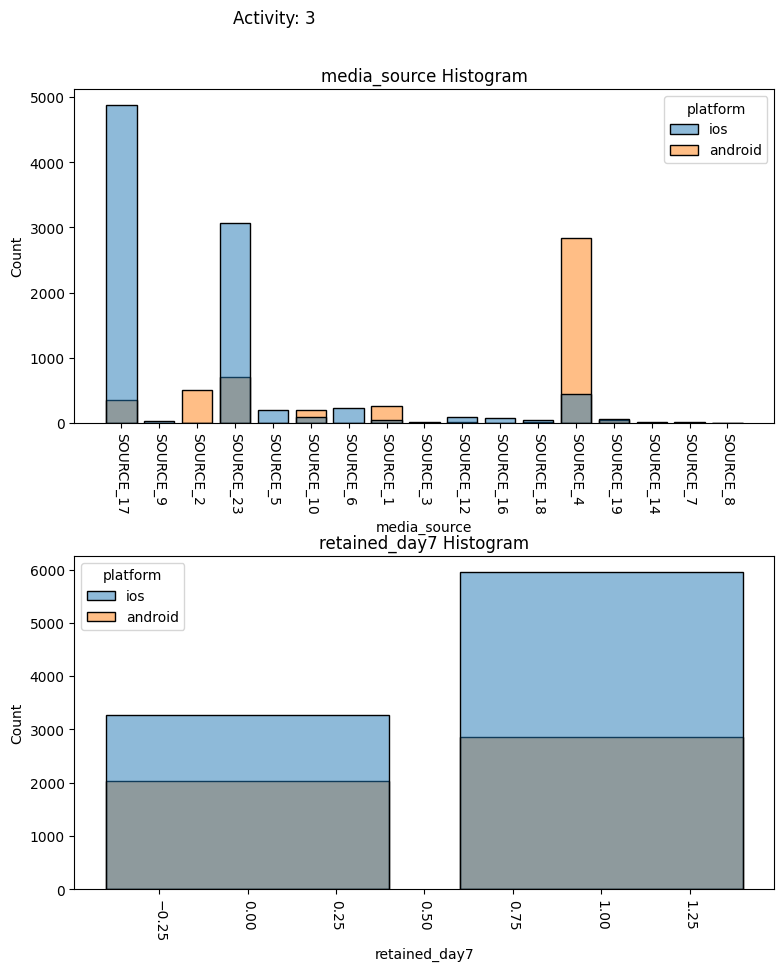

Empty DataFrame
Columns: []
Index: []

In [59]:
us.groupby('activity').apply(lambda x: show_dis_by_group(x, 'platform', [col for col in cat_cols if col not in ['platform', 'country_code']], 'cat', f'Activity: {x.name}'))

Features:
* Retantion: .
* Media source: ios users - SOURCE_17, SOURCE_23, android - SOURCE_4.

In [70]:
act_med_num = us.groupby('activity').apply(lambda x: x.groupby('media_source')['activity'].count().sort_values(ascending=False)[:10])
display(act_med_num)

activity  media_source
0         SOURCE_4        613337
          SOURCE_17       216935
          SOURCE_23       173276
          SOURCE_2         50979
          SOURCE_12        19548
          SOURCE_10        18020
          SOURCE_1         17580
          SOURCE_6          9551
          SOURCE_19         7919
          SOURCE_5          4952
1         SOURCE_4         74439
          SOURCE_17        55820
          SOURCE_23        34451
          SOURCE_2          7404
          SOURCE_10         3519
          SOURCE_1          3342
          SOURCE_6          2820
          SOURCE_12         2546
          SOURCE_19         1568
          SOURCE_5          1363
2         SOURCE_17        40647
          SOURCE_4         37891
          SOURCE_23        27103
          SOURCE_2          4352
          SOURCE_1          2176
          SOURCE_10         2146
          SOURCE_6          1880
          SOURCE_12         1250
          SOURCE_5          1050
          SOURCE_19 

Possible sources:
SOURCE_4 - Google Adds,
SOURCE_17 - recommendations in "similar apps",
SOURCE_23 - similar

In [71]:
act_count_num = us.groupby('activity').apply(lambda x: x.groupby('country_code')['activity'].count().sort_values(ascending=False)[:10])
display(act_count_num)

activity  country_code
0         COUNTRY_141     268863
          COUNTRY_13      221516
          COUNTRY_155     106225
          COUNTRY_108      99131
          COUNTRY_35       96721
          COUNTRY_137      72179
          COUNTRY_72       36245
          COUNTRY_38       36108
          COUNTRY_208      22884
          COUNTRY_189      16265
1         COUNTRY_141      65041
          COUNTRY_13       25354
          COUNTRY_155      25341
          COUNTRY_108      10072
          COUNTRY_35        9711
          COUNTRY_137       9319
          COUNTRY_72        7834
          COUNTRY_38        7311
          COUNTRY_208       4107
          COUNTRY_203       2013
2         COUNTRY_141      47870
          COUNTRY_155      18797
          COUNTRY_13       12552
          COUNTRY_72        5223
          COUNTRY_38        5078
          COUNTRY_108       5065
          COUNTRY_137       4795
          COUNTRY_35        4215
          COUNTRY_208       2734
          COUNTRY_20

COUNTRY_141 - most users from all groups. COUNTRY_155 - more active users, COUNTRY_13 - less active users.

In [72]:
act_inst_num = us.groupby('activity').apply(lambda x: x.groupby('install_date')['activity'].count().sort_values(ascending=False)[:10])
display(act_inst_num)

activity  install_date
0         2021-12-30      80009
          2021-12-29      60078
          2021-12-31      54686
          2021-12-26      47926
          2021-12-21      47423
          2021-12-24      46463
          2021-12-27      45404
          2022-01-02      42402
          2021-12-28      41843
          2021-12-23      41508
1         2021-12-30       8999
          2021-12-29       8263
          2021-12-21       7682
          2021-12-27       6946
          2021-12-26       6836
          2022-01-02       6713
          2021-12-22       6449
          2021-12-23       6301
          2021-12-28       5947
          2021-12-31       5903
2         2021-12-26       4756
          2021-12-21       4642
          2022-01-02       4635
          2021-12-30       4616
          2021-12-29       4514
          2021-12-27       4330
          2021-12-22       3848
          2021-12-23       3828
          2021-12-28       3547
          2022-01-03       3489
3         2021-12

Install date don't help to identify more active users.

In [18]:
dfs = {'a': us[us['platform'] == 'android'].reset_index(drop=True),
      'i': us[us['platform'] == 'ios'].reset_index(drop=True)}

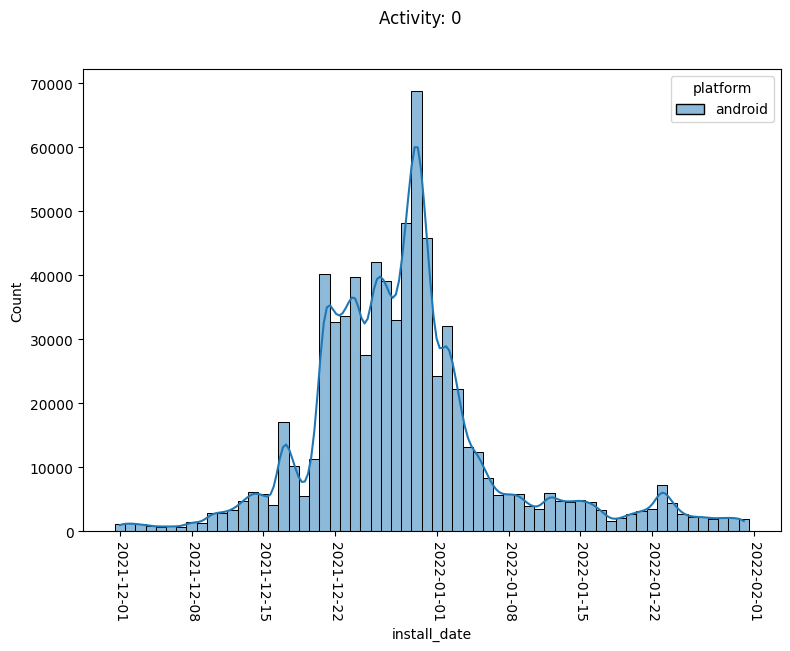

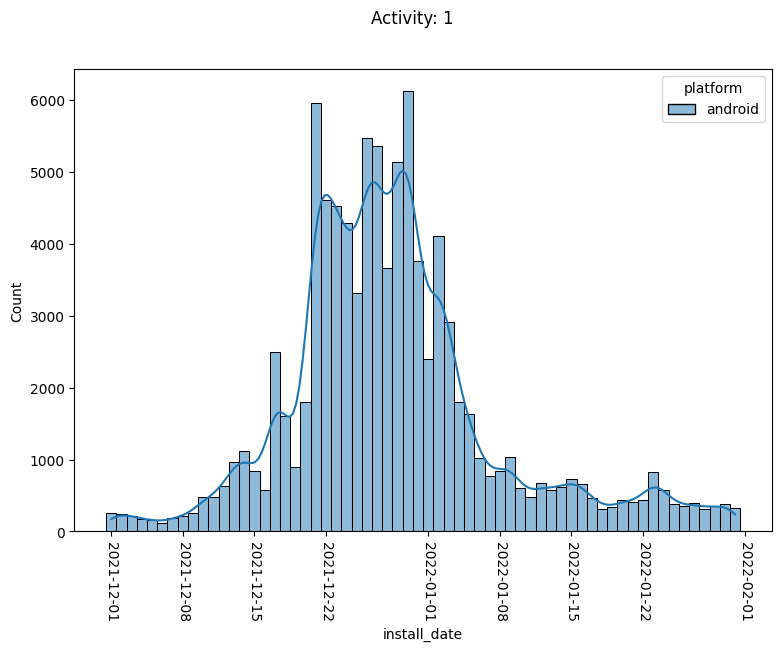

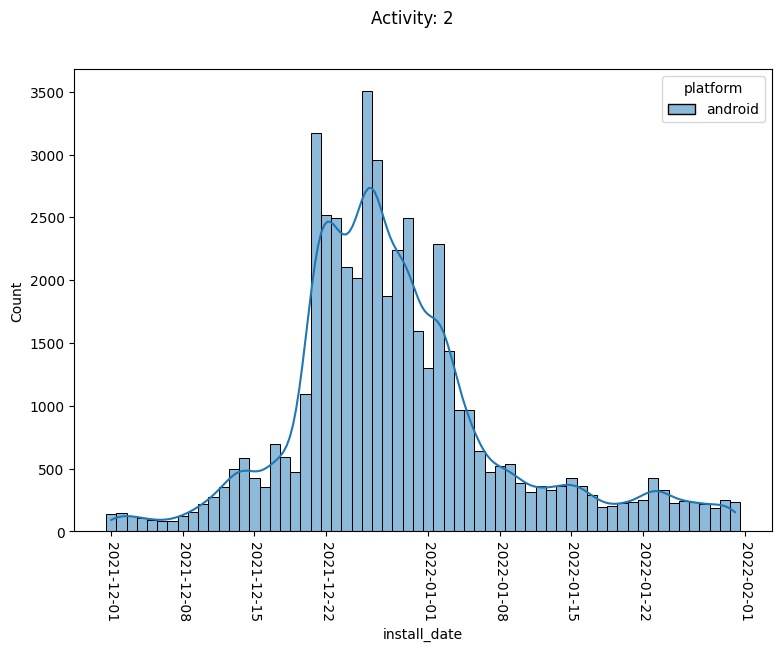

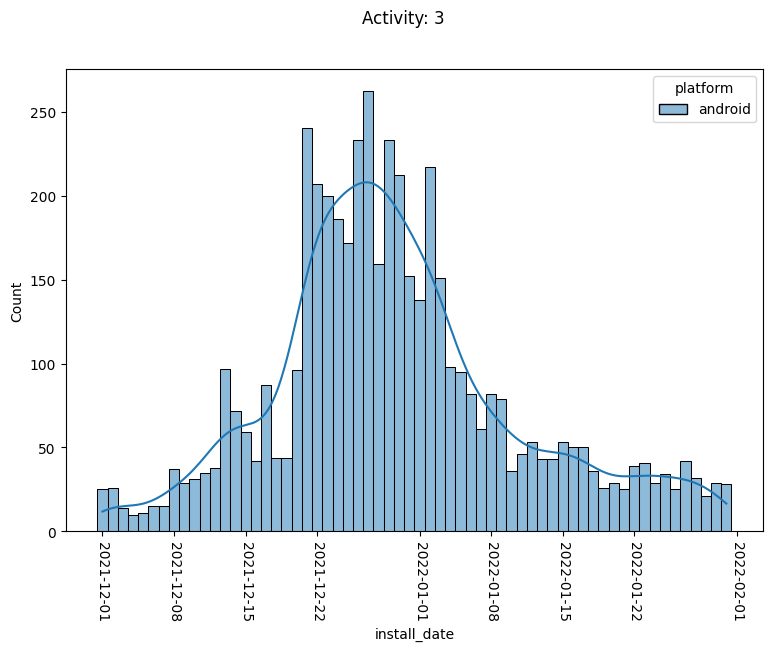

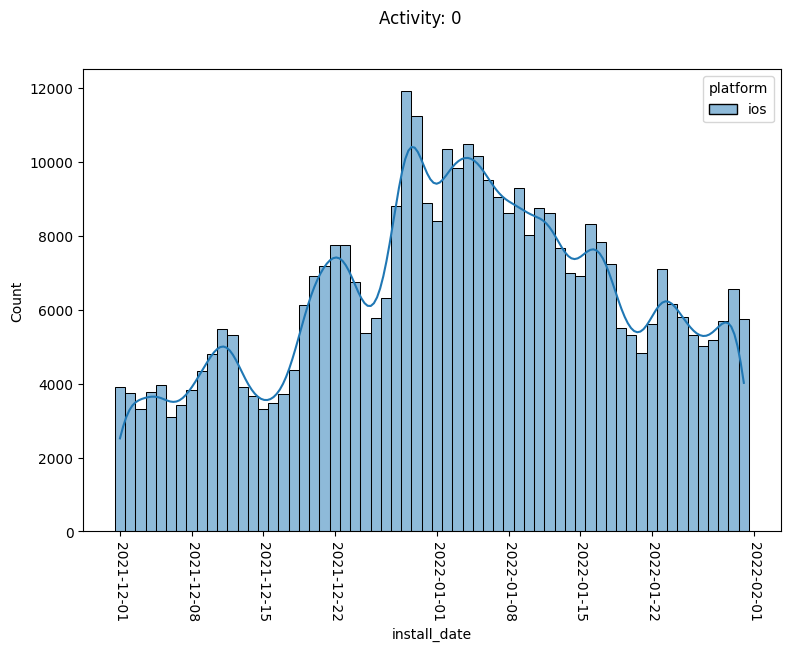

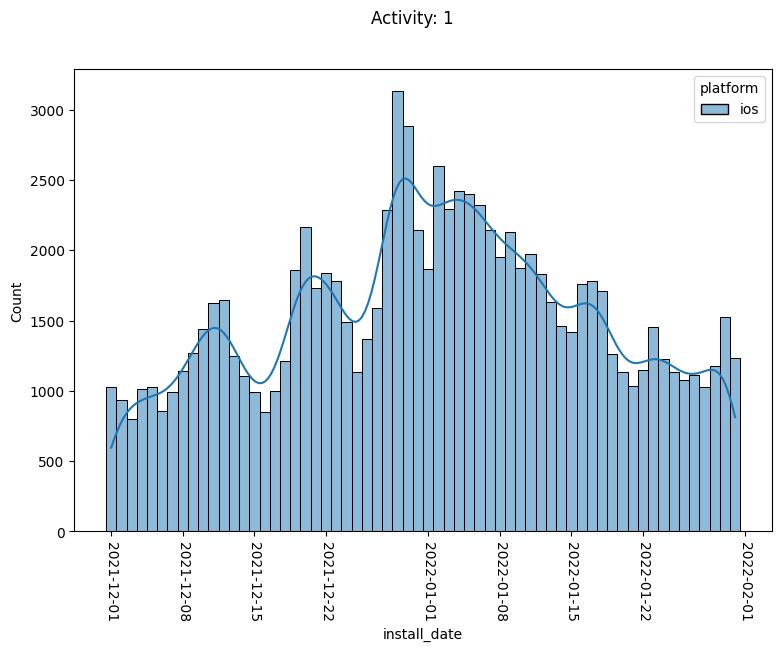

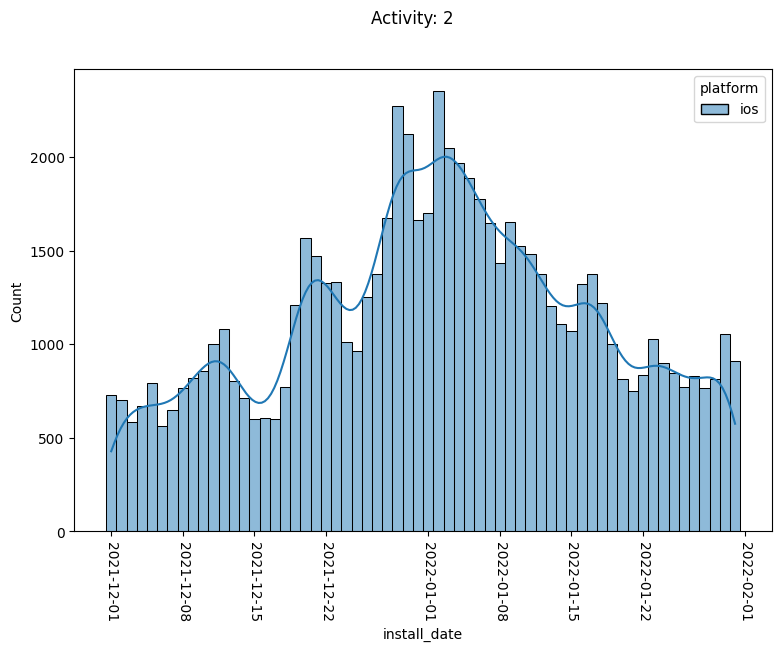

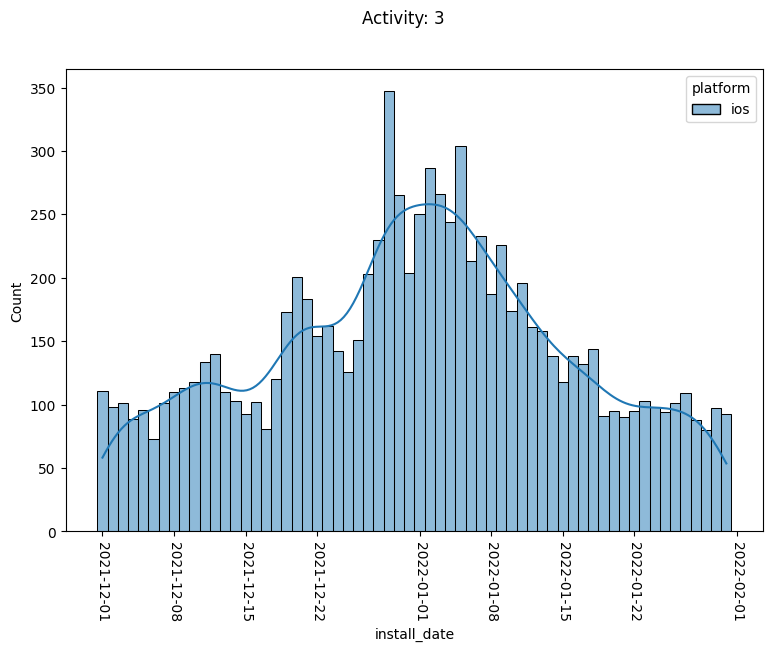

In [15]:
def plot_time_feat(x, hue_feature):
    fig = plt.figure(figsize=(9,6))
    fig.suptitle(f'Activity: {x.name}')
    sns.histplot(x='install_date', hue=hue_feature, data=x.sort_values('install_date'), discrete=True, kde=True)
    plt.xticks(rotation=-90)
    plt.show()

for platform in dfs:
    dfs[platform].groupby('activity').apply(plot_time_feat, hue_feature='platform')

Distribution of ios users is more uniform than android users. install_date can have an effect on user payability.

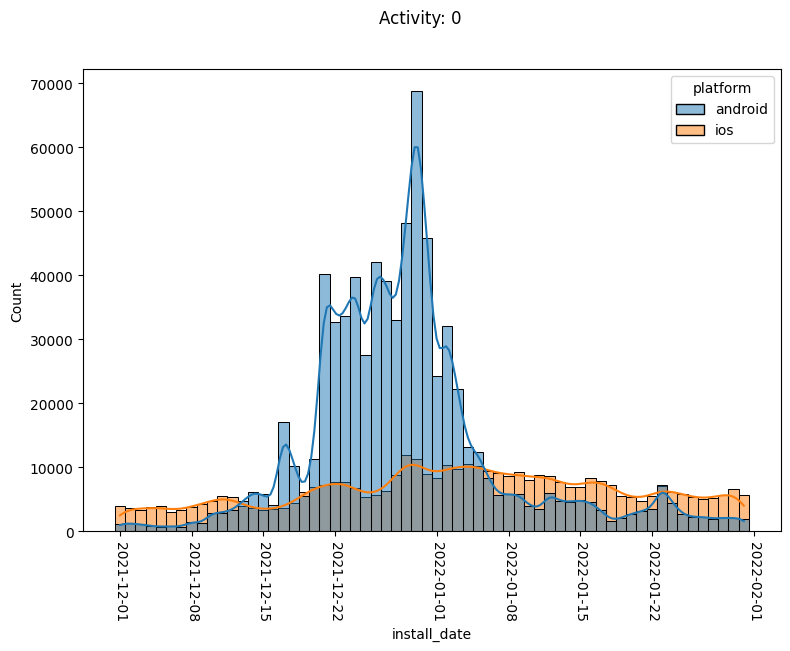

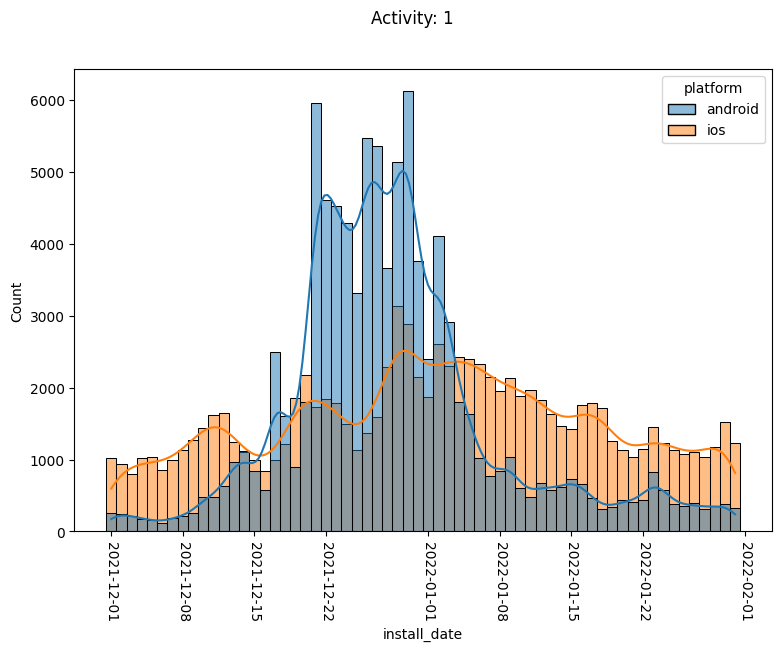

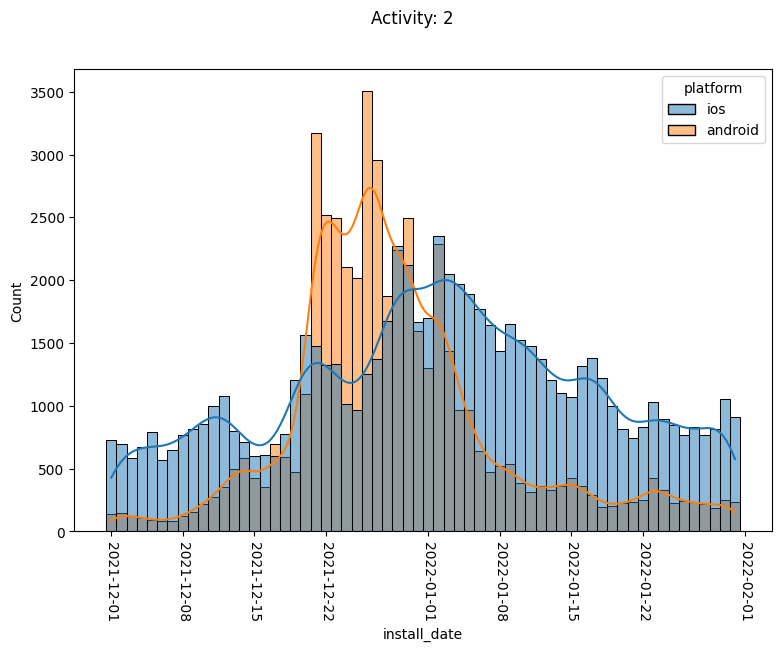

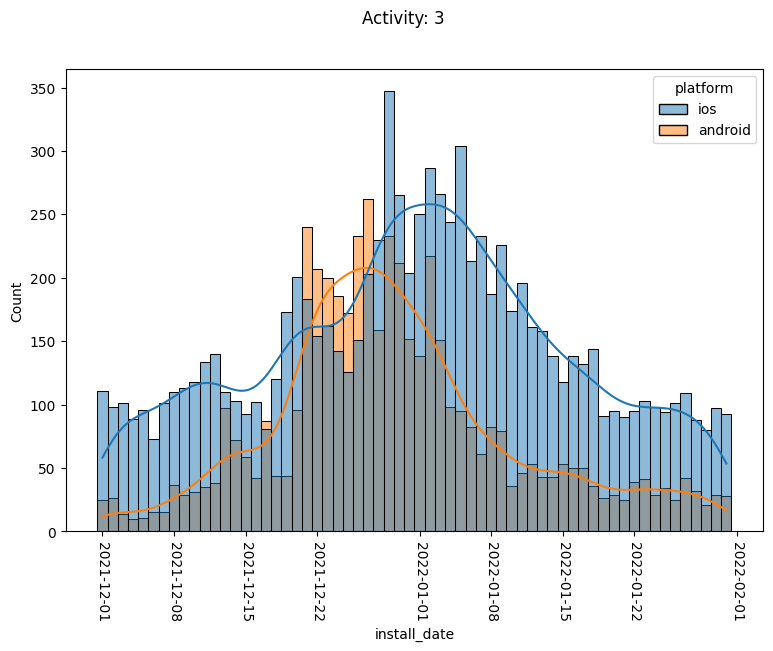

Empty DataFrame
Columns: []
Index: []

In [14]:
us.groupby('activity').apply(plot_time_feat)

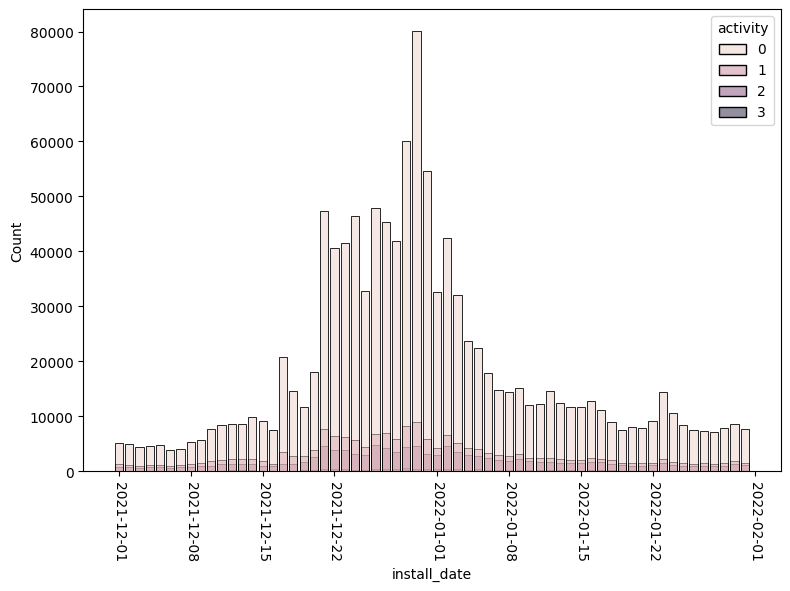

In [41]:
fig = plt.figure(num=1, clear=True, figsize=(9,6))
sns.histplot(x='install_date', data=us.sort_values('install_date'), hue='activity', discrete=True, shrink=.8)
plt.xticks(rotation=-90)
plt.show()

In [12]:
def get_high_corr_feats(mat, thr):
    '''
    Return high correlation features names, according to correlation matrix.
    '''
    tril_mat = mat.copy().to_numpy()
    triu_idx = np.triu_indices(tril_mat.shape[0])
    tril_mat[triu_idx] = 0
    corr_idx = np.column_stack(np.where(tril_mat >= thr))
    corr_info = list()
    for r, c in corr_idx:
        corr_val = mat.iat[r, c]
        corr_info.append((mat.index[r], mat.columns[c], corr_val))
    corr_info = pd.DataFrame(corr_info, columns = ["f1", "f2", "pearson"])
    corr_info = corr_info.sort_values(by=["f1"], ascending=False, axis=0)

    display(corr_info)

    return corr_info['f2'].unique()

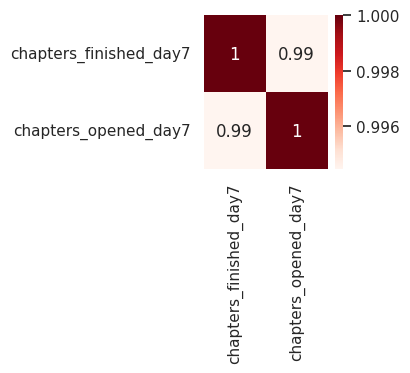

In [21]:
corr_mat = us[num_cols].corr()

sns.set(rc = {'figure.figsize':(2,2)})
sns.heatmap(corr_mat, annot=True, cmap='Reds')
plt.show()

In [22]:
hcorr_num_feat = get_high_corr_feats(corr_mat, 0.7)
hcorr_num_feat

f1                      f2   pearson
0  chapters_opened_day7  chapters_finished_day7  0.994459

0    chapters_finished_day7
Name: f2, dtype: object

In [27]:
def calc_cramers_v(df, cols):
    '''
    Return Cramer's V matrix and corresponding p-value matrix.
    '''
    cat_prod = list(product(cols, cols, repeat=1))
    chi_res = []
    cram_res = []
    for i in cat_prod:
        if i[0] != i[1]:
            chi_res.append((i[0], i[1],
                          list(ss.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]))
            cram_res.append((i[0], i[1],
                            ss.contingency.association(pd.crosstab(df[i[0]], df[i[1]]))))

    chi_df = pd.DataFrame(chi_res, columns = ["var1", "var2", "coeff"])
    cram_df = pd.DataFrame(cram_res, columns = ["var1", "var2", "coeff"])
    chi_df = chi_df.pivot(index = "var1", columns = "var2", values = "coeff")
    cram_df = cram_df.pivot(index = "var1", columns = "var2", values = "coeff")
    
    return cram_df, chi_df

def get_high_corr_pval_feats(assoc_mat, signif_mat, assoc_thr, signif_thr):
    tril_mat = assoc_mat.copy().to_numpy()
    triu_idx = np.triu_indices(tril_mat.shape[0])
    tril_mat[triu_idx] = 0
    assoc_idx = np.column_stack(np.where(tril_mat >= assoc_thr))
    assoc_info = list()
    for r, c in assoc_idx:
        sign_val = signif_mat.iat[r, c]
        assoc_val = assoc_mat.iat[r, c]
        if sign_val <= signif_thr:
            assoc_info.append((assoc_mat.index[r], assoc_mat.columns[c], assoc_val, sign_val))
    assoc_info = pd.DataFrame(assoc_info, columns = ["f1", "f2", "cramer", "p_val"])
    assoc_info = assoc_info.sort_values(by=["f1"], ascending=False, axis=0)

    display(assoc_info)

    hcorr_cat_feat = assoc_info['f2']

def plot_cramers_v(cram_df, chi_df):
    fig = plt.figure(num=1, clear=True, figsize=(5,5))
    fig.suptitle(f"Cramer's V")
    sns.heatmap(cram_df, annot = True, cmap = 'Reds')
    plt.show()
    
    fig = plt.figure(num=1, clear=True, figsize=(5,5))
    fig.suptitle(f"P-values")
    sns.heatmap(chi_df, annot = True, cmap = 'Reds')
    plt.show()

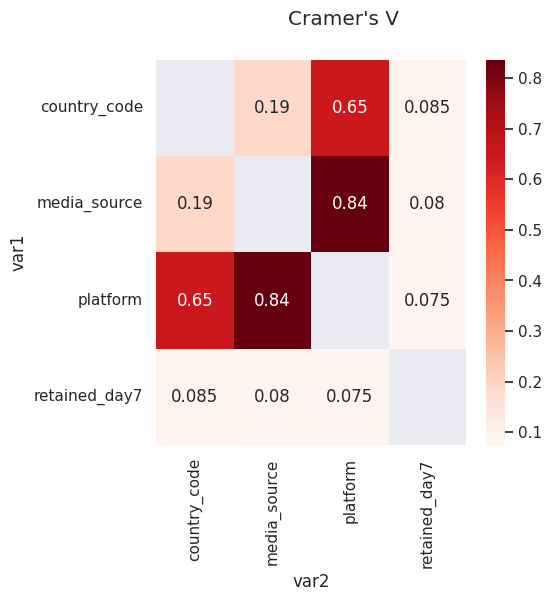

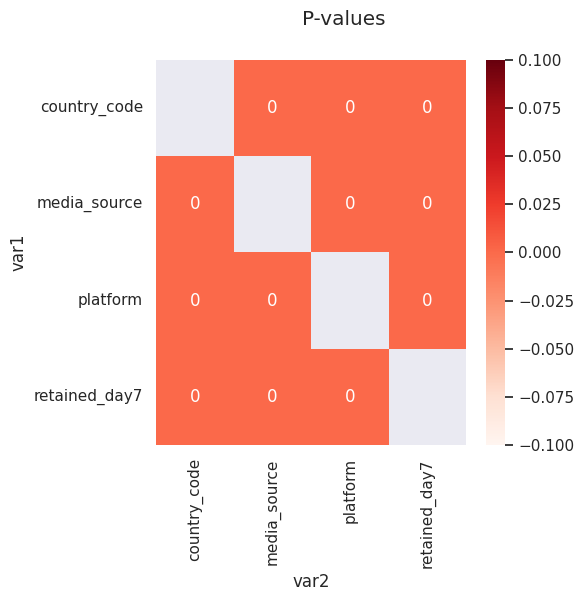

In [47]:
cram_df, chi_df = calc_cramers_v(us, cat_cols)
plot_cramers_v(cram_df, chi_df)

In [48]:
hcorr_cat_feat = get_high_corr_pval_feats(cram_df, chi_df, 0.7, 0.05)
hcorr_cat_feat

f1            f2    cramer  p_val
0  platform  media_source  0.836311    0.0

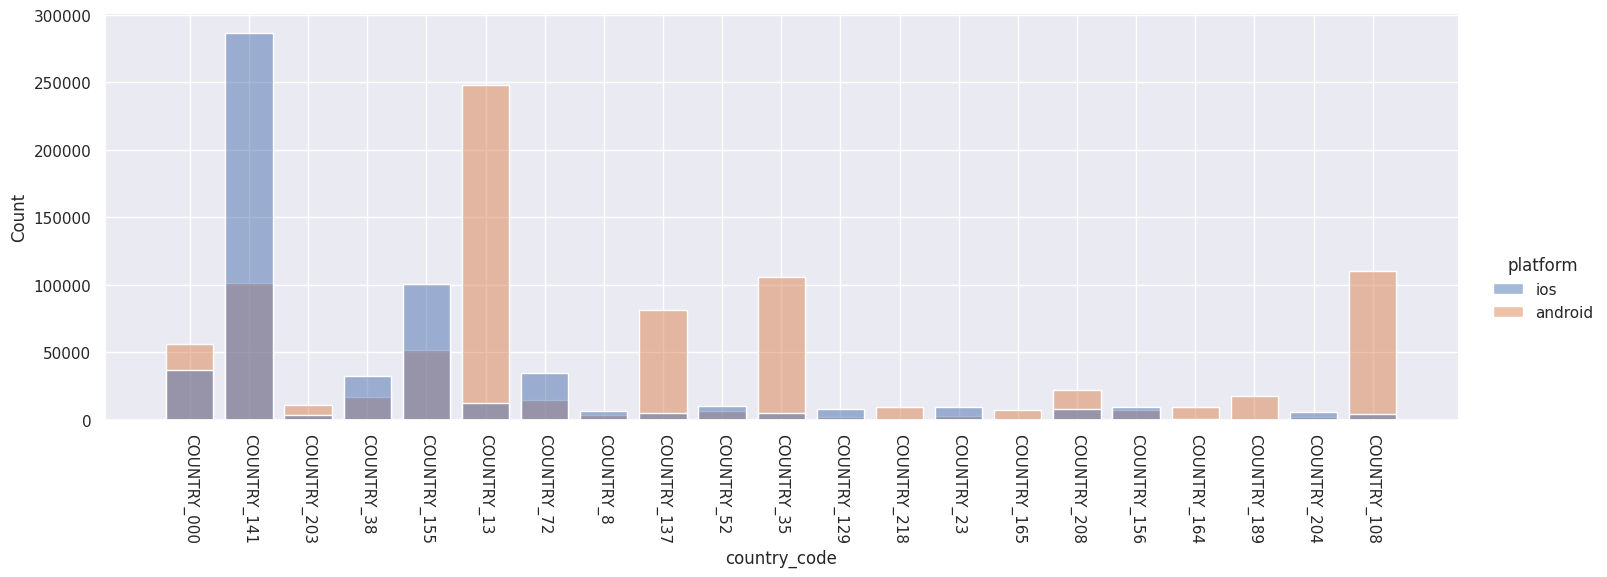

In [49]:
sns.displot(df, x='country_code', hue='platform', discrete=True, shrink=0.8, aspect=3)
plt.xticks(rotation=-90)
plt.show()

In [29]:
%reset_selective full_us

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [32]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
full_us = pd.read_pickle('./datasets/full_us.pkl')

In [5]:
targ = 'target_full_ltv_day30'
subtargs = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']
cat_cols = ['media_source', 'country_code', 'platform'] + [f'retained_day{i}' for i in [1, 3, 7]]
time_cols = ['install_date']
num_cols = [col for col in full_us.columns.values if col not in cat_cols + time_cols + subtargs + [targ]]

In [7]:
corr_mat = full_us[num_cols].corr()

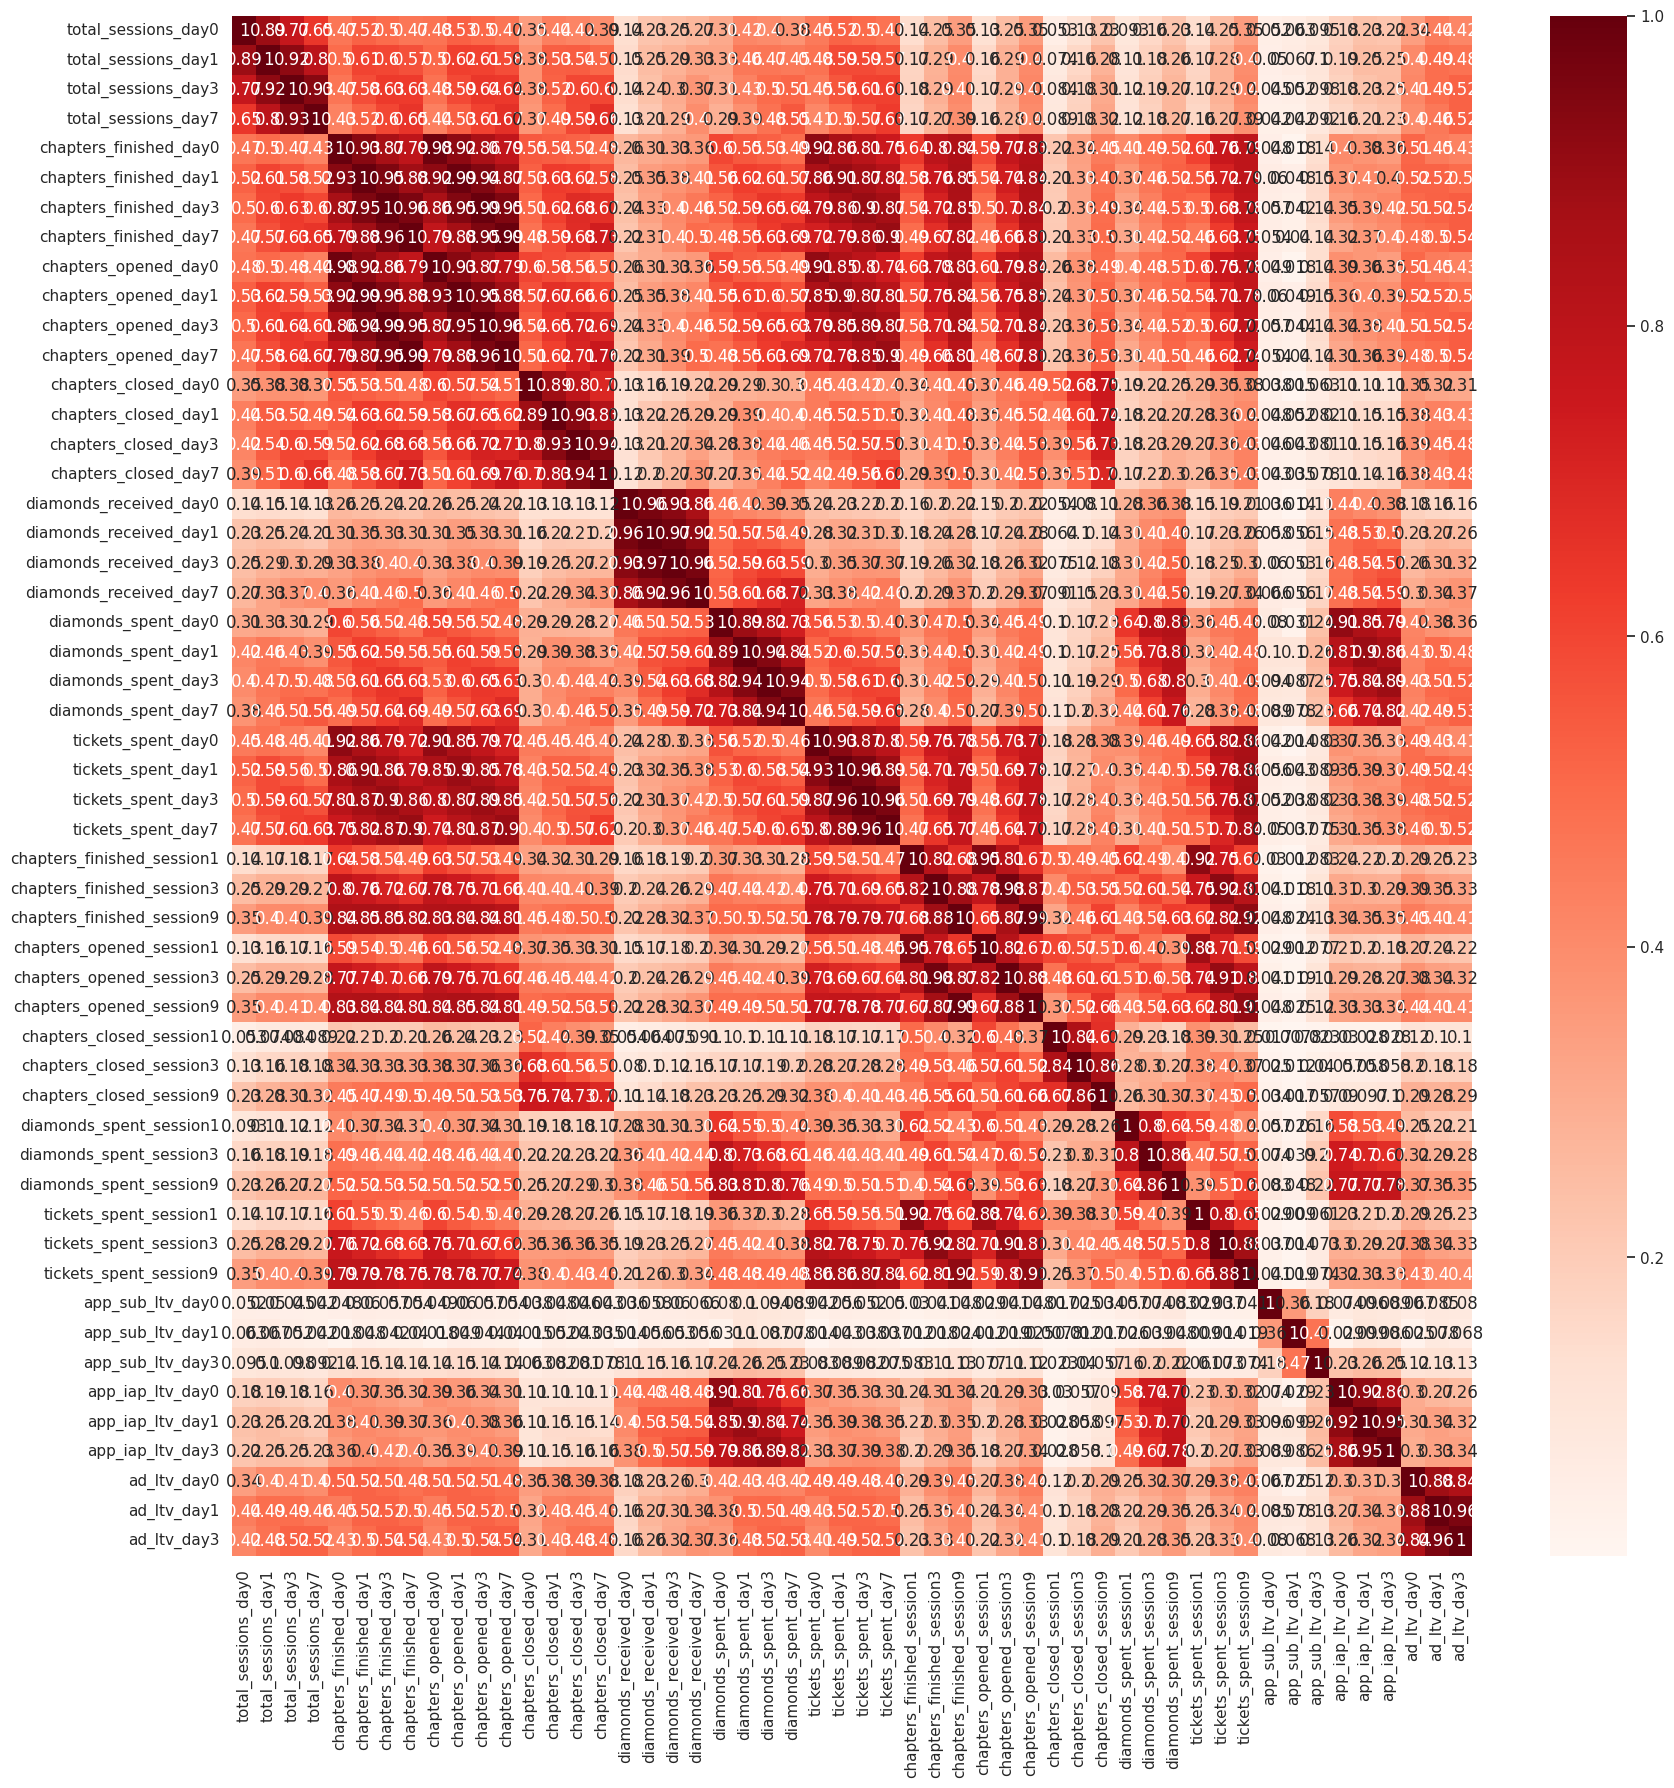

In [16]:
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(corr_mat, annot=True, cmap='Reds')
plt.show()

In [15]:
hcorr_num_feat = get_high_corr_feats(corr_mat, 0.8)
hcorr_num_feat.sort()
hcorr_num_feat

f1                          f2   pearson
2           total_sessions_day7         total_sessions_day1  0.803469
3           total_sessions_day7         total_sessions_day3  0.932322
1           total_sessions_day3         total_sessions_day1  0.921799
0           total_sessions_day1         total_sessions_day0  0.893938
120      tickets_spent_session9      tickets_spent_session3  0.876910
119      tickets_spent_session9    chapters_opened_session9  0.907227
118      tickets_spent_session9  chapters_finished_session9  0.916816
117      tickets_spent_session9  chapters_finished_session3  0.813646
116      tickets_spent_session9          tickets_spent_day7  0.842068
115      tickets_spent_session9          tickets_spent_day3  0.868531
114      tickets_spent_session9          tickets_spent_day1  0.864964
113      tickets_spent_session9          tickets_spent_day0  0.857656
109      tickets_spent_session3  chapters_finished_session3  0.923757
108      tickets_spent_session3          tickets_spent_day0  0.820833
111      tickets_spent_session3    chapters_opened_session3  0.905478
110      tickets_spent_session3  chapters_finished_session9  0.815770
112      tickets_spent_session3    chapters_opened_session9  0.807635
107      tickets_spent_session1    chapters_opened_session1  0.883105
106      tickets_spent_session1  chapters_finished_session1  0.924620
64           tickets_spent_day7      chapters_finished_day1  0.818044
72           tickets_spent_day7          tickets_spent_day3  0.955496
71           tickets_spent_day7          tickets_spent_day1  0.888014
70           tickets_spent_day7          tickets_spent_day0  0.804670
69           tickets_spent_day7        chapters_opened_day7  0.897652
68           tickets_spent_day7        chapters_opened_day3  0.866681
66           tickets_spent_day7      chapters_finished_day7  0.902010
65           tickets_spent_day7      chapters_finished_day3  0.870946
67           tickets_spent_day7        chapters_opened_day1  0.813116
54           tickets_spent_day3      chapters_finished_day0  0.807870
63           tickets_spent_day3          tickets_spent_day1  0.956309
62           tickets_spent_day3          tickets_spent_day0  0.872595
61           tickets_spent_day3        chapters_opened_day7  0.849365
60           tickets_spent_day3        chapters_opened_day3  0.893791
59           tickets_spent_day3        chapters_opened_day1  0.865292
58           tickets_spent_day3        chapters_opened_day0  0.800363
57           tickets_spent_day3      chapters_finished_day7  0.855122
56           tickets_spent_day3      chapters_finished_day3  0.899797
55           tickets_spent_day3      chapters_finished_day1  0.871600
51           tickets_spent_day1        chapters_opened_day1  0.898319
48           tickets_spent_day1      chapters_finished_day1  0.906080
47           tickets_spent_day1      chapters_finished_day0  0.856051
49           tickets_spent_day1      chapters_finished_day3  0.857607
52           tickets_spent_day1        chapters_opened_day3  0.850580
53           tickets_spent_day1          tickets_spent_day0  0.927753
50           tickets_spent_day1        chapters_opened_day0  0.847701
43           tickets_spent_day0      chapters_finished_day0  0.921678
44           tickets_spent_day0      chapters_finished_day1  0.855254
45           tickets_spent_day0        chapters_opened_day0  0.911829
46           tickets_spent_day0        chapters_opened_day1  0.846893
105     diamonds_spent_session9     diamonds_spent_session3  0.857755
102     diamonds_spent_session9         diamonds_spent_day0  0.826762
104     diamonds_spent_session9         diamonds_spent_day3  0.804115
103     diamonds_spent_session9         diamonds_spent_day1  0.809238
101     diamonds_spent_session3         diamonds_spent_day0  0.803408
41          diamonds_spent_day7         diamonds_spent_day1  0.843424
42          diamonds_spent_day7         diamonds_spent_day3  0.942430
39          diamonds_spent_day3        

array(['ad_ltv_day0', 'ad_ltv_day1', 'app_iap_ltv_day0',
       'app_iap_ltv_day1', 'chapters_closed_day0', 'chapters_closed_day1',
       'chapters_closed_day3', 'chapters_closed_session1',
       'chapters_closed_session3', 'chapters_finished_day0',
       'chapters_finished_day1', 'chapters_finished_day3',
       'chapters_finished_day7', 'chapters_finished_session1',
       'chapters_finished_session3', 'chapters_finished_session9',
       'chapters_opened_day0', 'chapters_opened_day1',
       'chapters_opened_day3', 'chapters_opened_day7',
       'chapters_opened_session1', 'chapters_opened_session3',
       'chapters_opened_session9', 'diamonds_received_day0',
       'diamonds_received_day1', 'diamonds_received_day3',
       'diamonds_spent_day0', 'diamonds_spent_day1',
       'diamonds_spent_day3', 'diamonds_spent_day7',
       'diamonds_spent_session3', 'tickets_spent_day0',
       'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7',
       'tickets_spent_session3'

In [17]:
df = full_us[[f'total_sessions_day{i}' for i in [0, 1, 3, 7]]]
df.head()

total_sessions_day0  total_sessions_day1  total_sessions_day3  \
0                  1.0                  1.0                  1.0   
1                  1.0                  1.0                  1.0   
2                  1.0                  2.0                  2.0   
3                  1.0                  1.0                  1.0   
4                  1.0                  1.0                  1.0   

   total_sessions_day7  
0                  1.0  
1                  1.0  
2                  2.0  
3                  1.0  
4                  1.0

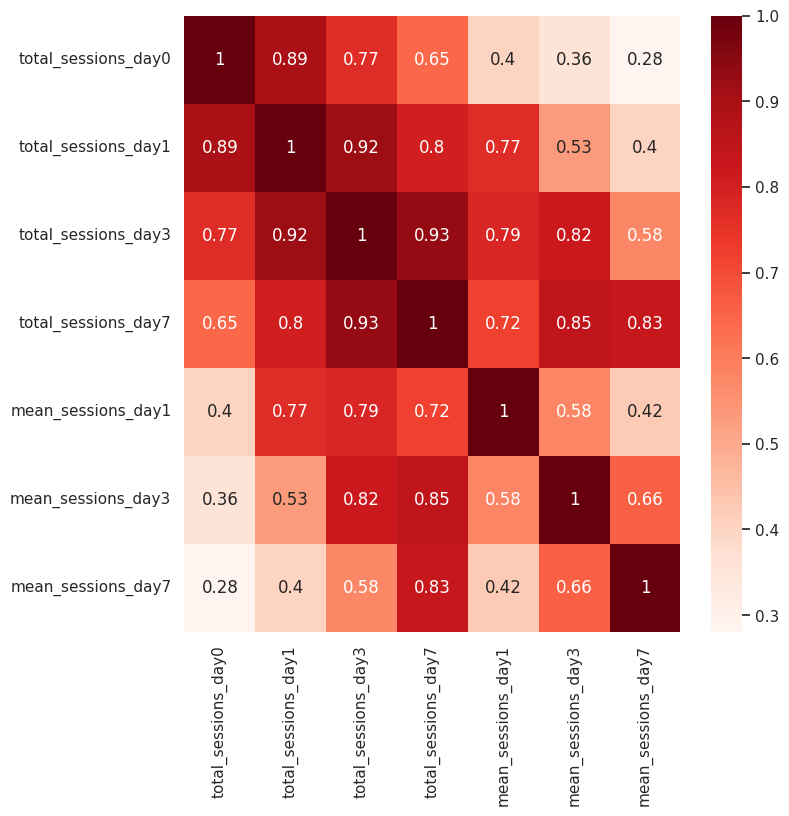

In [28]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(df.corr(), annot=True, cmap='Reds')
plt.show()

In [25]:
df['mean_sessions_day1'] = (df['total_sessions_day1'] - df['total_sessions_day0']) / 1
df['mean_sessions_day3'] = (df['total_sessions_day3'] - df['total_sessions_day1']) / 2
df['mean_sessions_day7'] = (df['total_sessions_day7'] - df['total_sessions_day3']) / 4
df.tail()

/tmp/ipykernel_15923/944707961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_sessions_day1'] = (df['total_sessions_day1'] - df['total_sessions_day0']) / 1
/tmp/ipykernel_15923/944707961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_sessions_day3'] = (df['total_sessions_day3'] - df['total_sessions_day1']) / 2
/tmp/ipykernel_15923/944707961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

total_sessions_day0  total_sessions_day1  total_sessions_day3  \
1467827                 11.0                 11.0                 11.0   
1467828                  2.0                  3.0                  6.0   
1467829                  3.0                  5.0                 11.0   
1467830                  5.0                  5.0                  5.0   
1467831                  6.0                  7.0                  7.0   

         total_sessions_day7  mean_sessions_day1  mean_sessions_day3  \
1467827                 11.0                 0.0                 0.0   
1467828                  7.0                 1.0                 1.5   
1467829                 13.0                 2.0                 3.0   
1467830                  5.0                 0.0                 0.0   
1467831                  7.0                 1.0                 0.0   

         mean_sessions_day7  
1467827                0.00  
1467828                0.25  
1467829                0.50  
1467830                0.00  
1467831                0.00

In [6]:
us.head()

chapters_finished_day7  chapters_opened_day7  retained_day7 media_source  \
0                       0                     0              0    SOURCE_23   
1                       0                     0              0     SOURCE_2   
2                       0                     0              0    SOURCE_17   
3                       0                     0              0    SOURCE_23   
4                       0                     0              0     SOURCE_1   

  install_date country_code platform  
0   2021-12-03  COUNTRY_000      ios  
1   2021-12-03  COUNTRY_141  android  
2   2021-12-03  COUNTRY_141  android  
3   2021-12-03  COUNTRY_141      ios  
4   2021-12-03  COUNTRY_203  android

In [17]:
def oh_encode_n_popular(df, columns_params={}):
    '''
    Return dataframe with passed category groupby_columns, simplified
    to most popular n values, found in grouped sum of top_col,
    and one-hot encoded.
    
    Parameters
    ----------
    columns_params: Columns, corresponding most popular n values to leave
    and default value in format {groupby_col: (top_col, n, default_value)}.
    
    Info
    ----------
    df: Passed by copy in function. Threfore, edited inside.
    
    Warnings
    ----------
    Index in df must be reset.
    '''
    oh_cols = pd.DataFrame()
    for groupby_col, (top_col, num, default_value) in columns_params.items():
        top_categories = df.groupby(groupby_col)[top_col].sum().sort_values(ascending=False)[:num].index.values
        simplified_col = np.where(df[groupby_col].isin(top_categories), df[groupby_col], default_value)
        oh_col = pd.get_dummies(simplified_col)
        oh_cols = oh_col.join(oh_cols, how='left')
    df = df.drop(columns_params.keys(), axis=1)
    df = df.join(oh_cols)
    return df

In [15]:
columns_params = {'media_source': (TARGET, 5, 'SOURCE_000'),
                 'country_code': (TARGET, 5, 'COUNTRY_000')}
df = oh_encode_n_popular(android_us, columns_params)

In [18]:
android_us.groupby('country_code')[TARGET].sum().sort_values(ascending=False)[:5].index.values

array(['COUNTRY_141', 'COUNTRY_155', 'COUNTRY_38', 'COUNTRY_72',
       'COUNTRY_13'], dtype=object)

In [16]:
df.head()

platform  retained_day7 install_date  target_full_ltv_day30  COUNTRY_000  \
1   android              0   2021-12-03                    0.0          0.0   
2   android              0   2021-12-03                    0.0          1.0   
4   android              0   2021-12-03                    0.0          1.0   
5   android              0   2021-12-03                    0.0          0.0   
15  android              0   2021-12-03                    0.0          1.0   

    COUNTRY_13  COUNTRY_141  COUNTRY_155  COUNTRY_38  COUNTRY_72  SOURCE_000  \
1          0.0          1.0          0.0         0.0         0.0         0.0   
2          0.0          0.0          0.0         0.0         0.0         0.0   
4          0.0          0.0          0.0         0.0         0.0         0.0   
5          0.0          1.0          0.0         0.0         0.0         1.0   
15         0.0          0.0          0.0         0.0         0.0         1.0   

    SOURCE_1  SOURCE_10  SOURCE_17  SOURCE_2  SOURCE_4  
1        0.0        0.0        1.0       0.0       0.0  
2        1.0        0.0        0.0       0.0       0.0  
4        0.0        0.0        0.0       1.0       0.0  
5        0.0        0.0        0.0       0.0       0.0  
15       0.0        0.0        0.0       0.0       0.0

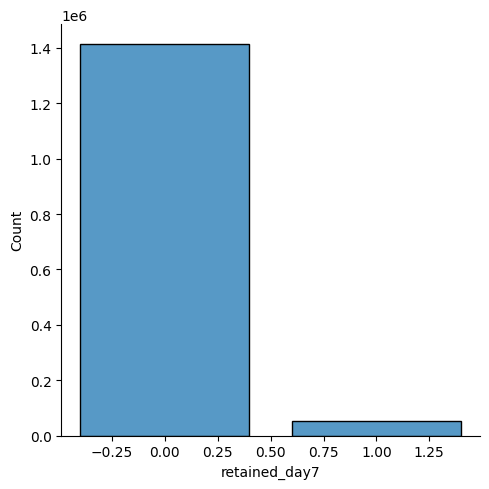

In [8]:
sns.displot(x='retained_day7', data=us, discrete=True, shrink=0.8)

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [8]:
def kft_split(df, target, stratify=None):
    '''
    Return dictionary of form
    {'test': test_idx,
     'sep_0': {'train': train_idx,
                'valid': valid_idx},
     ...,
     'sep_9': ...}
    '''
    if stratify is None:
        stratify = target
    
    split_dict = {}

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0, stratify=df[stratify])
    
    split_dict['test'] = X_test.index

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    
    stratify_train = X_train[stratify]
    i = 0
    for train_idx, valid_idx in skf.split(X_train, stratify_train):
        # fold_X_train, fold_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        # fold_y_train, fold_y_valid = y[train_idx], y[valid_idx]
        split_dict[f'sep_{i}'] = {'train': train_idx,
                                  'valid': valid_idx}
        i += 1

    return split_dict

def save_obj_pkl(obj, f_name):
    with open(f_name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
android = us
android['payable'] = np.where(android[TARGET] > 1, 1, 0)
kft_dict = kft_split(android, TARGET, 'payable')
save_obj_pkl(kft_dict, './datasets/android_num_kft.pkl')

In [11]:
kft_dict = kft_split(us, 'media_source', 'retained_day7')

In [22]:
# t2 = tt['sep_7']['valid']
t2 = tt['test']
t2 = us.iloc[t2]['retained_day7']
# display(t2.head())
t2[t2 == 0].size / t2.size
# t2

0.964219338452902

In [17]:
t2 = tt['fold_4']['train'][1]
display(t2.head())

0    SOURCE_23
1     SOURCE_2
2    SOURCE_17
3    SOURCE_23
4     SOURCE_1
Name: media_source, dtype: object

In [24]:
%reset_selective tt

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y
